# Model Evaluation Part 3 -- Cross-Validation and Model Selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## K-fold Cross-Validation in Scikit-Learn

- Simple demonstration of using a cross-validation iterator in scikit-learn

In [2]:
from sklearn.model_selection import KFold


rng = np.random.RandomState(123)

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
X = rng.random_sample((y.shape[0], 4))


cv = KFold(n_splits=5)

for k in cv.split(X, y):
    print(k)

(array([2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1]))
(array([0, 1, 4, 5, 6, 7, 8, 9]), array([2, 3]))
(array([0, 1, 2, 3, 6, 7, 8, 9]), array([4, 5]))
(array([0, 1, 2, 3, 4, 5, 8, 9]), array([6, 7]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([8, 9]))


- In practice, we are usually interested in shuffling the dataset, because if the data records are ordered by class label, this would result in cases where the classes are not well represented in the training and test folds

In [3]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)

for k in cv.split(X, y):
    print(k)

(array([1, 2, 3, 5, 6, 7, 8, 9]), array([0, 4]))
(array([0, 1, 2, 3, 4, 6, 8, 9]), array([5, 7]))
(array([0, 1, 2, 4, 5, 6, 7, 9]), array([3, 8]))
(array([0, 2, 3, 4, 5, 7, 8, 9]), array([1, 6]))
(array([0, 1, 3, 4, 5, 6, 7, 8]), array([2, 9]))


- Note that the `KFold` iterator only provides us with the array indices; in practice, we are actually interested in the array values (feature values and class labels)

In [4]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)

for train_idx, valid_idx in cv.split(X, y):
    print('train labels with shuffling', y[train_idx])

train labels with shuffling [0 0 0 1 1 1 1 1]
train labels with shuffling [0 0 0 0 0 1 1 1]
train labels with shuffling [0 0 0 0 1 1 1 1]
train labels with shuffling [0 0 0 0 1 1 1 1]
train labels with shuffling [0 0 0 0 1 1 1 1]


- As discussed in the lecture, it's important to stratify the splits (very crucial for small datasets!)

In [5]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

for train_idx, valid_idx in cv.split(X, y):
    print('train labels', y[train_idx])

train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]


- After the illustrations of cross-validation above, the next cell demonstrates how we can actually use the iterators provided through scikit-learn to fit and evaluate a learning algorithm

In [6]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)



cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

kfold_acc = 0.
for train_idx, valid_idx in cv.split(X_train, y_train):
    clf = DecisionTreeClassifier(random_state=123, max_depth=3).fit(X_train[train_idx], y_train[train_idx])
    y_pred = clf.predict(X_train[valid_idx])
    acc = np.mean(y_pred == y_train[valid_idx])*100
    kfold_acc += acc
kfold_acc /= 10
    
clf = DecisionTreeClassifier(random_state=123, max_depth=3).fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = np.mean(y_pred == y_test)*100
    
print('Kfold Accuracy: %.2f%%' % kfold_acc)
print('Test Accuracy: %.2f%%' % test_acc)



Kfold Accuracy: 95.26%
Test Accuracy: 95.65%


- Usually, a more convenient way to use cross-validation through scikit-learn is to use the `cross_val_score` function (note that it performs stratifies splitting for classification by default)
- (remember to ask students about whitespaces according to pep8)

In [7]:
from sklearn.model_selection import cross_val_score


cv_acc = cross_val_score(estimator=DecisionTreeClassifier(random_state=123, max_depth=3),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 96.09%


- `cross_val_score` has unfortunately no way to specify a random seed; this is not an issue in regular use cases, but it is not useful if you want to do "repeated cross-validation"
- The next cell illustrates how we can provide our own cross-validation iterator for convenience (note that the results match or "manual" `StratifiedKFold` approach we performed earlier)

In [8]:
from sklearn.model_selection import cross_val_score


cv_acc = cross_val_score(estimator=DecisionTreeClassifier(random_state=123, max_depth=3),
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 95.26%


## GridSearch

- For hyperparameter tuning and model selection, `GridSearchCV` is really useful

In [9]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)

In [10]:
from sklearn.model_selection import GridSearchCV


param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

Best Accuracy: 96.09%
Best Params: {'criterion': 'gini', 'max_depth': 3}


In [11]:
for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i]) 

0.653846153846154 {'criterion': 'gini', 'max_depth': 1}
0.9121794871794873 {'criterion': 'gini', 'max_depth': 2}
0.9608974358974359 {'criterion': 'gini', 'max_depth': 3}
0.951923076923077 {'criterion': 'gini', 'max_depth': 4}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 5}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 6}
0.9602564102564102 {'criterion': 'gini', 'max_depth': None}
0.653846153846154 {'criterion': 'entropy', 'max_depth': 1}
0.9121794871794873 {'criterion': 'entropy', 'max_depth': 2}
0.9608974358974359 {'criterion': 'entropy', 'max_depth': 3}
0.9365384615384617 {'criterion': 'entropy', 'max_depth': 4}
0.9448717948717948 {'criterion': 'entropy', 'max_depth': 5}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': 6}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': None}


- We an summarize the results in a heatmap, but note that this only works if you have 1 or 2 hyperparameters to consider

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

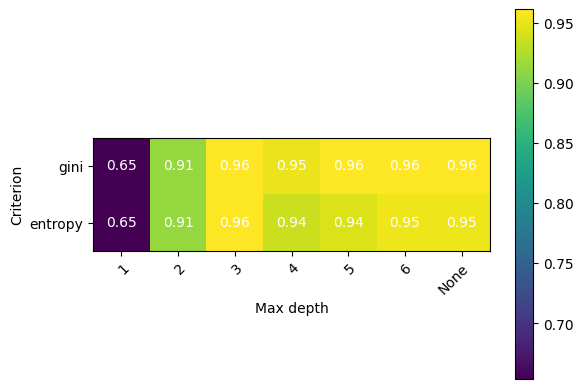

In [13]:
from mlxtend.plotting import heatmap
import numpy as np
import pandas as pd

grid = np.zeros((2, 7))
grid[0, :] = gs.cv_results_['mean_test_score'][:7]
grid[1, :] = gs.cv_results_['mean_test_score'][7:]


heatmap(grid, 
        column_names=[1, 2, 3, 4, 5, 6, "None"], 
        row_names=['gini', 'entropy'])
plt.ylabel('Criterion')
plt.xlabel('Max depth')
plt.show()

- After running `GridSearchCV`, we would fit a model with the best settings (hyperparameters on the whole training set
- By default, `GridSearchCV` already does this for us (unless, we set `refit=False`), so that we can evaluate the performance of the model on the test set

In [14]:
# gs.best_estimator_.fit(X_train, y_train)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Accuracy: 95.65%


## Randomized Search

- Here, each setting is sampled from a distribution (discrete or continuous) over possible parameter values
- Instead of running all combinations exhaustively like in GridSearch, a budget is specified (`n_iter` specifies the number of candidates to evaluate)

### ParamSampler

- To explain these concepts, let's take a look at the `ParamSampler` first, which is used under the hood of the `RandomizedSearchCV`; it will help us building some intuition.

As we can see in the example below, lists are also supported; they will behave like gridsearch

In [15]:
from sklearn.model_selection import ParameterSampler


d = {'parameter 1': [1, 2, 3, 4, 5, 6, 7], 
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 2': 'b', 'parameter 1': 4},
 {'parameter 2': 'a', 'parameter 1': 6},
 {'parameter 2': 'a', 'parameter 1': 3},
 {'parameter 2': 'a', 'parameter 1': 1},
 {'parameter 2': 'b', 'parameter 1': 3},
 {'parameter 2': 'b', 'parameter 1': 5},
 {'parameter 2': 'a', 'parameter 1': 5},
 {'parameter 2': 'b', 'parameter 1': 6},
 {'parameter 2': 'b', 'parameter 1': 2},
 {'parameter 2': 'b', 'parameter 1': 1}]

- We can define probability distributions using SciPy's selection of distributions (https://docs.scipy.org/doc/scipy/reference/stats.html).

- Consider a discrete random uniform distribution for parameter 1 (note that in this case, there is a sampling with replacement from the distribution)

In [16]:
import scipy.stats

d = {'parameter 1': scipy.stats.randint(low=1, high=4), # integer between 1-3
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'a'},
 {'parameter 1': 1, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'a'}]

- below is an example for sampling from a uniform continuous distribution:

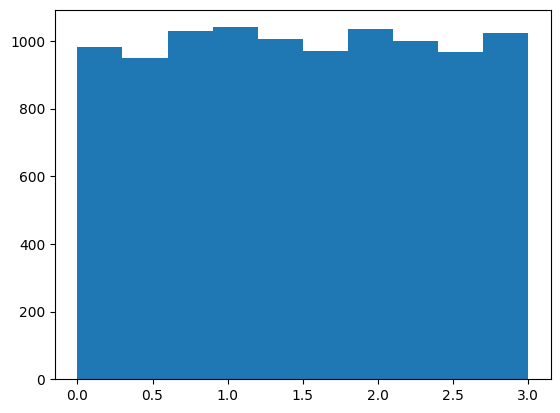

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.hist(scipy.stats.uniform(loc=0, scale=3).rvs(10000))
plt.show()

In [18]:
d = {'parameter 1': scipy.stats.uniform(loc=0, scale=3), # float between 1-3
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 1': 2.089407556793585, 'parameter 2': 'a'},
 {'parameter 1': 1.285412778560477, 'parameter 2': 'a'},
 {'parameter 1': 1.6539443072486737, 'parameter 2': 'b'},
 {'parameter 1': 1.473356800297792, 'parameter 2': 'b'},
 {'parameter 1': 2.9422925951538463, 'parameter 2': 'a'},
 {'parameter 1': 1.7390828910678304, 'parameter 2': 'b'},
 {'parameter 1': 1.1763525545824516, 'parameter 2': 'a'},
 {'parameter 1': 1.8819510280128502, 'parameter 2': 'b'},
 {'parameter 1': 1.3157167340388733, 'parameter 2': 'b'},
 {'parameter 1': 2.084265531555807, 'parameter 2': 'a'}]

### RandomizedSeachCV example

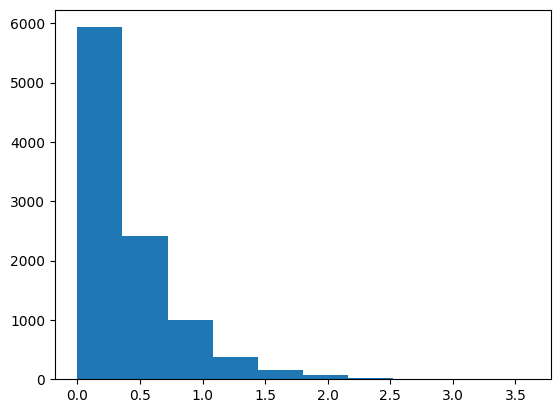

In [19]:
plt.hist(scipy.stats.expon(scale=0.4).rvs(10000))
plt.show()

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [21]:
gbm = HistGradientBoostingClassifier(random_state=123)

d = {'learning_rate': scipy.stats.expon(scale=0.4),
     'max_depth': scipy.stats.randint(low=3, high=10),
     'l2_regularization': scipy.stats.uniform(loc=0, scale=1)}

rcv = RandomizedSearchCV(estimator=gbm,
                         param_distributions=d, 
                         n_iter=200,
                         cv=10,
                         refit=True,
                         random_state=123,
                         n_jobs=-1)

rcv.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (rcv.best_score_*100))
print('Best Params:', rcv.best_params_)

Best Accuracy: 96.73%
Best Params: {'l2_regularization': 0.7770044388897804, 'learning_rate': 0.011352363969357031, 'max_depth': 5}


## K-fold and standard deviation (1-standard error method)

- Below is an application of the 1-standard error method we discussed in class (to select hyperparameters according to the "Law of Parsimony")

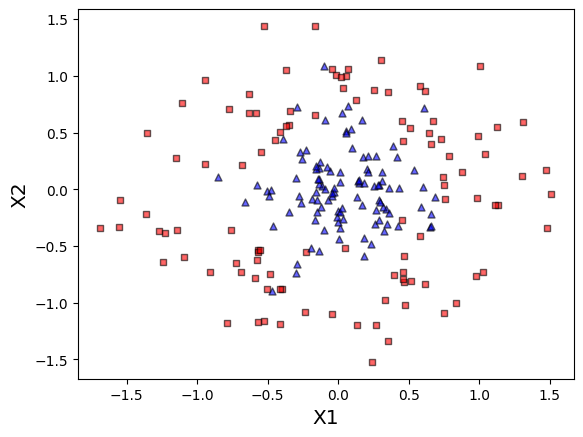

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles


X, y = make_circles(n_samples=300, random_state=1, noise=0.275, factor=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=12345,
                                                    stratify=y)

plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
            marker='s', color='red', edgecolor='k', alpha=0.6, s=25)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
            marker='^', color='blue', edgecolor='k', alpha=0.6, s=25)
plt.xlabel('X1', fontsize=14.5)
plt.ylabel('X2', fontsize=14.5)

plt.show()

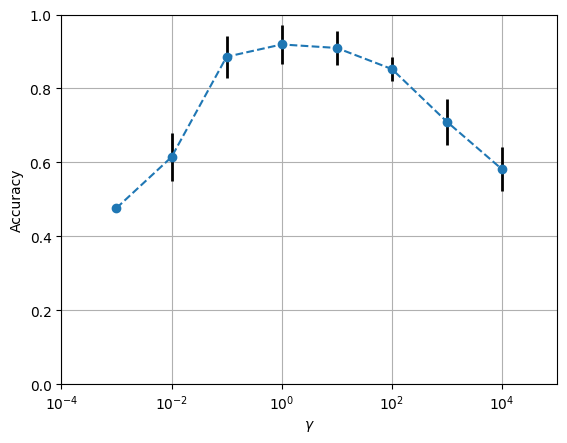

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape='ovo', 
              random_state=0)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

## PLOTTING

ax = plt.subplot(111)
ax.set_xscale('log')
ax.errorbar(params, cv_acc, yerr=cv_std, fmt='--o', ecolor='black', elinewidth=2)


plt.ylim([0.0, 1.0])
plt.xlim([0.0001, 100000.0])
plt.grid()
plt.xlabel('$\\gamma$')
plt.ylabel('Accuracy')
plt.show()

- Below is a visualization of the decision boundary of the "most parsimonious" hyperparameter choice

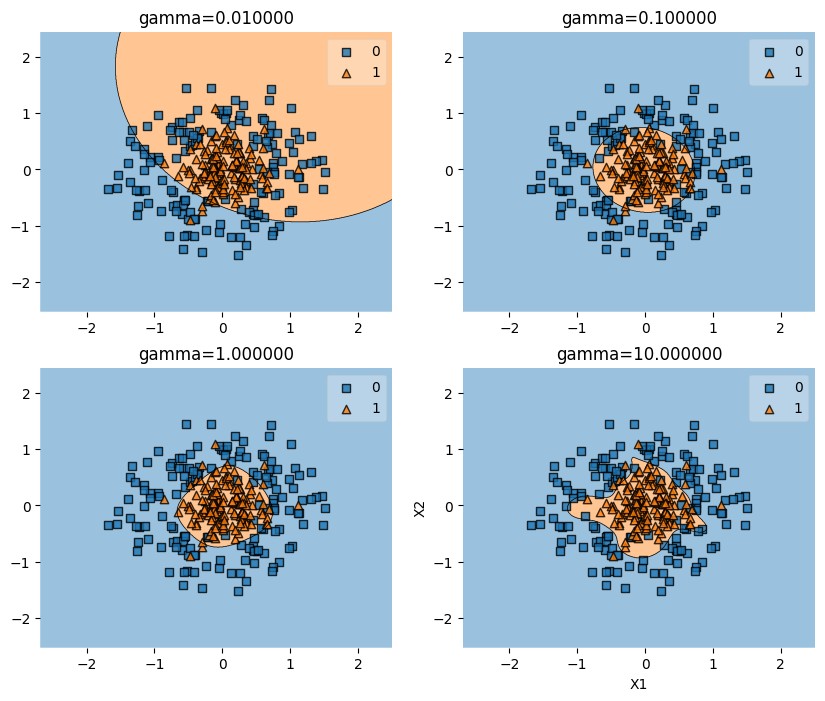

In [24]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


gspec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for c, grd in zip([0.01, 0.1, 1.0, 10.], itertools.product([0, 1], repeat=2)):

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape='ovo', 
              random_state=0)

    clf.fit(X_train, y_train)
    ax = plt.subplot(gspec[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title('gamma=%f' % c)


plt.xlabel('X1') 
plt.ylabel('X2')

plt.show()

- The following cells in this section repeat the procedure of choosing the most parsimonious hyperparameter using decision trees and two features of the Iris dataset (petal length and petal width)

In [25]:
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)


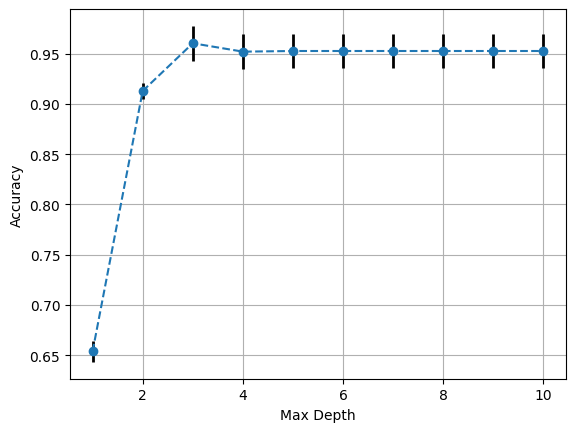

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold


params = range(1, 11)
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = DecisionTreeClassifier(random_state=123, max_depth=c)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

## PLOTTING

ax = plt.subplot(111)
ax.errorbar(params, cv_acc, yerr=cv_stderr, fmt='--o', ecolor='black', elinewidth=2)


plt.grid()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

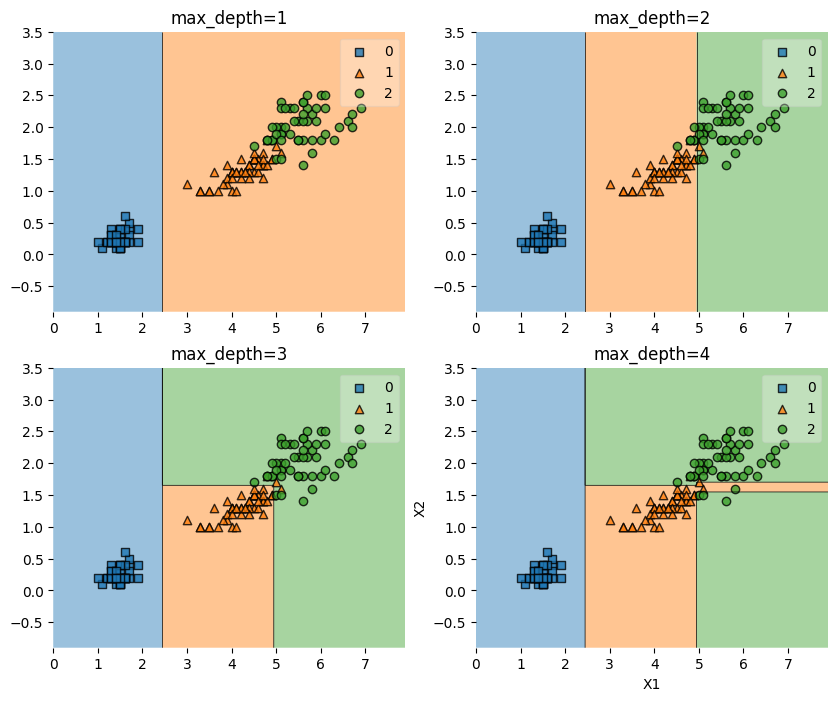

In [27]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


gspec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for c, grd in zip([1, 2, 3, 4], itertools.product([0, 1], repeat=2)):

    clf = DecisionTreeClassifier(random_state=123, max_depth=c)

    clf.fit(X_train, y_train)
    ax = plt.subplot(gspec[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title('max_depth=%d' % c)


plt.xlabel('X1') 
plt.ylabel('X2')

plt.show()

## Algorithm Comparison (Nested Cross-Validation)

This notebook illustrates how to implement nested cross-validation in scikit-learn.

<img src="images/nested-cv-image.png" width=400>


- Setting up classifiers (or pipelines) and the parameter grids for model tuning
- Remember, the hyperparameter tuning takes place in the inner loop

In [28]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.data import mnist_data
from sklearn.metrics import accuracy_score

# Loading and splitting the dataset
# Note that this is a small (stratified) subset
# of MNIST; it consists of 5000 samples only, that is,
# 10% of the original MNIST dataset
# http://yann.lecun.com/exdb/mnist/
X, y = mnist_data()
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

# Initializing Classifiers
clf1 = LogisticRegression(multi_class='auto',
                          solver='liblinear',
                          random_state=1)
clf2 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=50)
clf3 = DecisionTreeClassifier(random_state=1)
clf4 = SVC(random_state=1)
clf5 = RandomForestClassifier(random_state=1)

# Building the pipelines for data standardization. Tree-based models
# (DecisionTreeClassifier, RandomForestClassifier) do not require
# standardization, so we will not include them in the pipeline.
pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', clf1)])

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', clf2)])

pipe4 = Pipeline([('std', StandardScaler()),
                  ('clf4', clf4)])


# Setting up the parameter grids
param_grid1 = [{'clf1__penalty': ['l2'],
                'clf1__C': np.power(10., np.arange(-4, 4))}]

param_grid2 = [{'clf2__n_neighbors': list(range(1, 10)),
                'clf2__p': [1, 2]}]

param_grid3 = [{'max_depth': list(range(1, 10)) + [None],
                'criterion': ['gini', 'entropy']}]

param_grid4 = [{'clf4__kernel': ['rbf'],
                'clf4__C': np.power(10., np.arange(-4, 4)),
                'clf4__gamma': np.power(10., np.arange(-5, 0))},
               {'clf4__kernel': ['linear'],
                'clf4__C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

In [29]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4, param_grid5),
                            (pipe1, pipe2, clf3, pipe4, clf5),
                            ('Softmax', 'KNN', 'DTree', 'SVM', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

- Next, we define the outer loop
- The training folds from the outer loop will be used in the inner loop for model tuning
- The inner loop selects the best hyperparameter setting
- This best hyperparameter setting can be evaluated on both the avg. over the inner test folds and the 1 corresponding test fold of the outer loop

In [30]:
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        gridcvs[name].fit(X_train[train_idx], y_train[train_idx]) # run inner loop hyperparam tuning
        print('\n        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (valid_idx)
        outer_scores.append(gridcvs[name].best_estimator_.score(X_train[valid_idx], y_train[valid_idx]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:



        Best ACC (avg. of inner test folds) 72.59%
        Best parameters: {'criterion': 'gini', 'max_depth': None}
        ACC (on outer test fold) 75.50%

        Best ACC (avg. of inner test folds) 74.03%
        Best parameters: {'criterion': 'entropy', 'max_depth': 7}
        ACC (on outer test fold) 78.25%

        Best ACC (avg. of inner test folds) 73.88%
        Best parameters: {'criterion': 'entropy', 'max_depth': 9}
        ACC (on outer test fold) 77.38%

        Best ACC (avg. of inner test folds) 73.38%
        Best parameters: {'criterion': 'entropy', 'max_depth': 8}
        ACC (on outer test fold) 74.88%

        Best ACC (avg. of inner test folds) 73.91%
        Best parameters: {'criterion': 'entropy', 'max_depth': 8}
        ACC (on outer test fold) 77.75%

    Outer Loop:
        ACC 76.75% +/- 1.32
-------------------------------------------------- 

Algorithm: KNN
    Inner loop:

        Best ACC (avg. of inner test folds) 88.38%
        Best parameters: {'cl

------

- Determine the best algorithm from the experiment above; e.g., we find that Random Forest is performing best
- Now, select a hyperparameters for the model based on regular k-fold on the whole training set

In [31]:
gcv_model_select = GridSearchCV(estimator=clf5,
                                param_grid=param_grid5,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best CV accuracy: 93.30%
Best parameters: {'n_estimators': 10000}


- Using these settings, we can now train the best model to the whole training set

In [32]:
## We can skip the next step because we set refit=True
## so scikit-learn has already fit the model to the
## whole training set

# gcv_model_select.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=gcv_model_select.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=gcv_model_select.predict(X_test))

print('Training Accuracy: %.2f%%' % (100 * train_acc))
print('Test Accuracy: %.2f%%' % (100 * test_acc))

Training Accuracy: 100.00%
Test Accuracy: 94.00%


For comparison, previously, we have seen that using this algorithm, that the avg. outer fold accuracy was 

    ACC 93.98% +/- 0.98